In [ ]:
import pandas as pd

# Step 1: Load CSV file
df = pd.read_csv("filterdata1.csv", parse_dates=["Timestamp"])

# Step 2: Filter QuoteUpdate and TradeReport
quotes = df[df["Message_Type"] == "QuoteUpdate"].copy()
trades = df[df["Message_Type"] == "TradeReport"].copy()

# Step 3: Clean missing values and invalid data
quotes.dropna(subset=["Bid_Price", "Ask_Price"], inplace=True)
trades.dropna(subset=["Price", "Size"], inplace=True)
# Remove rows where prices are 0
quotes = quotes[(quotes["Bid_Price"] != 0) & (quotes["Ask_Price"] != 0)].copy()
trades = trades[trades["Price"] != 0].copy()

# Step 4: Define the start time
start_time = pd.Timestamp("2025-02-20 14:30:00+00:00")

# Filter trades and quotes to start at or after 14:30:00
quotes = quotes[quotes["Timestamp"] >= start_time].copy()
trades = trades[trades["Timestamp"] >= start_time].copy()

# Step 5: Prepare quotes and trades for combination
quotes.set_index("Timestamp", inplace=True)
trades.set_index("Timestamp", inplace=True)

# Step 6: Create HLCV bars for each symbol (e.g., 1s frequency)
barsDB = {}
all_hlcv = []

# Output file
output_file = "barsDB.csv"

for symbol in trades["Symbol"].unique():
    # Filter trades and quotes for the symbol
    symbol_trades = trades[trades["Symbol"] == symbol].copy()
    symbol_quotes = quotes[quotes["Symbol"] == symbol].copy()

    # Skip if no trades or quotes for the symbol
    if symbol_trades.empty and symbol_quotes.empty:
        continue

    # Prepare trades DataFrame
    trades_df = symbol_trades[["Price", "Size"]].copy()
    trades_df["Bid_Price"] = float("nan")
    trades_df["Ask_Price"] = float("nan")
    trades_df["Source"] = "Trade"

    # Prepare quotes DataFrame
    quotes_df = symbol_quotes[["Bid_Price", "Ask_Price"]].copy()
    quotes_df["Price"] = float("nan")
    quotes_df["Size"] = "Bid_Price"+"Ask_Size"
    quotes_df["Source"] = "Quote"

    # Combine trades and quotes
    combined_df = pd.concat([trades_df, quotes_df], sort=False)
    combined_df.sort_index(inplace=True)

    # Define the end time for resampling
    end_time = combined_df.index.max() if not combined_df.empty else start_time
    if end_time < start_time:
        continue

    # Create a continuous 1-second time index starting at 14:30:00
    time_index = pd.date_range(start=start_time, end=end_time, freq="1S")

    # Resample to 1-second bars (only high, low, volume)
    hlcv = combined_df.resample("1S").agg({
        "Bid_Price": "min",  # For low
        "Ask_Price": "max",  # For high
        "Size": "sum"        # For volume
    })

    # Rename columns (no open or close)
    hlcv.columns = ["low", "high", "volume"]

    # Reindex to ensure the time series starts at 14:30:00
    hlcv = hlcv.reindex(time_index)

    # Adjust high and low to include trade prices
    price_high = combined_df["Price"].resample("1S").max().reindex(time_index)
    hlcv["high"] = hlcv["high"].combine_first(price_high).ffill()
    price_low = combined_df["Price"].resample("1S").min().reindex(time_index)
    hlcv["low"] = hlcv["low"].combine_first(price_low).ffill()

    # Step 7: Calculate additional columns
    hlcv["average"] = hlcv[["high", "low"]].mean(axis=1)
    hlcv["SMA"] = hlcv["average"].rolling(window=10, min_periods=1).mean()
    hlcv["EMA"] = hlcv["average"].ewm(span=10, adjust=False).mean()

    # Step 8: Handle missing values
    hlcv.ffill(inplace=True)
    hlcv.fillna(0, inplace=True)

    # Skip intervals where high and low are both 0
    hlcv = hlcv[~((hlcv["high"] == 0) & (hlcv["low"] == 0))]

    # Add Symbol column
    hlcv["Symbol"] = symbol

    # Reset index to make Timestamp a column
    hlcv = hlcv.reset_index().rename(columns={"index": "Timestamp"})

    # Save to barsDB
    barsDB[symbol] = hlcv

    # Append to the list
    all_hlcv.append(hlcv)

# Step 9: Combine and write to CSV
if all_hlcv:
    combined_hlcv = pd.concat(all_hlcv, ignore_index=True)
    # Explicitly exclude open and close in the final output
    combined_hlcv = combined_hlcv[["Timestamp", "Symbol", "high", "low", "volume", "average", "SMA", "EMA"]]
    combined_hlcv.to_csv(output_file, index=False)
    print(f"Saved HLCV bars with quotes to: {output_file}")
else:
    print("No data to save.")

/tmp/ipykernel_4922/3214407198.py:4: DtypeWarning: Columns (24,25,28,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("filterdata1.csv", parse_dates=["Timestamp"])
/tmp/ipykernel_4922/3214407198.py:66: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_index = pd.date_range(start=start_time, end=end_time, freq="1S")
/tmp/ipykernel_4922/3214407198.py:69: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  hlcv = combined_df.resample("1S").agg({
/tmp/ipykernel_4922/3214407198.py:82: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  price_high = combined_df["Price"].resample("1S").max().reindex(time_index)
/tmp/ipykernel_4922/3214407198.py:84: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  price_low = combined_df["Price"].resample("1S").min

Saved HLCV bars with quotes to: barsDB.csv


In [ ]:
import pandas as pd

# Step 1: Load CSV file
df = pd.read_csv("filter_NVDA.csv", parse_dates=["Timestamp"])

# Step 2: Filter QuoteUpdate and TradeReport
quotes = df[df["Message_Type"] == "QuoteUpdate"].copy()
trades = df[df["Message_Type"] == "TradeReport"].copy()

# Step 3: Clean missing values and invalid data
quotes.dropna(subset=["Bid_Price", "Ask_Price", "Bid_Size", "Ask_Size"], inplace=True)
trades.dropna(subset=["Price", "Size"], inplace=True)
# Remove rows where prices are 0
quotes = quotes[(quotes["Bid_Price"] != 0) & (quotes["Ask_Price"] != 0)].copy()
trades = trades[trades["Price"] != 0].copy()

# Step 4: Define the start time
start_time = pd.Timestamp("2025-02-20 14:30:00+00:00")

# Filter trades and quotes to start at or after 14:30:00
quotes = quotes[quotes["Timestamp"] >= start_time].copy()
trades = trades[trades["Timestamp"] >= start_time].copy()

# Step 5: Prepare quotes and trades for combination
quotes.set_index("Timestamp", inplace=True)
trades.set_index("Timestamp", inplace=True)

# Step 6: Create bars for each symbol (1s frequency)
barsDB = {}
all_bars = []

# Output file
output_file = "barsDBase.csv"

for symbol in trades["Symbol"].unique():
    # Filter trades and quotes for the symbol
    symbol_trades = trades[trades["Symbol"] == symbol].copy()
    symbol_quotes = quotes[quotes["Symbol"] == symbol].copy()

    # Skip if no trades or quotes for the symbol
    if symbol_trades.empty and symbol_quotes.empty:
        continue

    # Prepare trades DataFrame
    trades_df = symbol_trades[["Price", "Size"]].copy()
    trades_df["Bid_Price"] = float("nan")
    trades_df["Ask_Price"] = float("nan")
    trades_df["Bid_Size"] = float("nan")
    trades_df["Ask_Size"] = float("nan")
    trades_df["Source"] = "Trade"

    # Prepare quotes DataFrame
    quotes_df = symbol_quotes[["Bid_Price", "Ask_Price", "Bid_Size", "Ask_Size"]].copy()
    quotes_df["Price"] = float("nan")
    quotes_df["Size"] = quotes_df["Bid_Size"] + quotes_df["Ask_Size"]  # Volume contribution from quotes
    quotes_df["Source"] = "Quote"

    # Combine trades and quotes
    combined_df = pd.concat([trades_df, quotes_df], sort=False)
    combined_df.sort_index(inplace=True)

    # Define the end time for resampling
    end_time = combined_df.index.max() if not combined_df.empty else start_time
    if end_time < start_time:
        continue

    # Create a continuous 1-second time index starting at 14:30:00
    time_index = pd.date_range(start=start_time, end=end_time, freq="1S")

    # Resample to 1-second bars (max, min, volume)
    bars = combined_df.resample("1S").agg({
        "Bid_Price": "min",  # For min
        "Ask_Price": "max",  # For max
        "Price": ["max", "min"],  # For max and min from trades
        "Size": "sum"  # For volume (trades + quotes)
    })

    # Flatten multi-index columns and rename
    bars.columns = ["bid_price", "ask_price", "price_max", "price_min", "volume"]

    # Reindex to ensure the time series starts at 14:30:00
    bars = bars.reindex(time_index)

    # Calculate max and min by combining trade prices and quote prices
    bars["max"] = bars[["ask_price", "price_max"]].max(axis=1)  # Max of Ask_Price and trade Price
    bars["min"] = bars[["bid_price", "price_min"]].min(axis=1)  # Min of Bid_Price and trade Price

    # Drop temporary columns
    bars = bars.drop(columns=["bid_price", "ask_price", "price_max", "price_min"])

    # Step 7: Calculate additional columns
    # Average updates every 1 second
    bars["average"] = bars[["max", "min"]].mean(axis=1)

    # Calculate SMA and EMA over the entire day
    # First, handle missing values in average for SMA/EMA calculation
    temp_bars = bars[["average"]].copy()
    temp_bars.ffill(inplace=True)
    temp_bars.fillna(0, inplace=True)
    # Exclude intervals where max and min are both 0 to avoid skewing
    valid_bars = temp_bars[~((bars["max"] == 0) & (bars["min"] == 0))]
    if not valid_bars.empty:
        daily_sma = valid_bars["average"].mean()  # SMA over the entire day
        # EMA: Use the last EMA value as the "daily" EMA
        daily_ema = valid_bars["average"].ewm(span=10, adjust=False).mean()[-1]
    else:
        daily_sma = 0.0
        daily_ema = 0.0

    # Assign the daily SMA and EMA to all rows
    bars["SMA"] = daily_sma
    bars["EMA"] = daily_ema

    # Step 8: Handle missing values for other columns
    #bars[["max", "min", "volume"]] = bars[["max", "min", "volume"]].ffill()
    #bars.fillna(0, inplace=True)

    # Skip intervals where max and min are both 0
    bars = bars[~((bars["max"] == 0) & (bars["min"] == 0))]

    # Add Symbol column
    bars["Symbol"] = symbol

    # Reset index to make Timestamp a column
    bars = bars.reset_index().rename(columns={"index": "Timestamp"})

    # Save to barsDB
    barsDB[symbol] = bars

    # Append to the list
    all_bars.append(bars)

# Step 9: Combine and write to CSV
if all_bars:
    combined_bars = pd.concat(all_bars, ignore_index=True)
    combined_bars = combined_bars[["Timestamp", "Symbol", "max", "min", "volume", "average", "SMA", "EMA"]]
    combined_bars.to_csv(output_file, index=False)
    print(f"Saved bars with custom requirements to: {output_file}")
else:
    print("No data to save.")

/tmp/ipykernel_172642/149576020.py:4: DtypeWarning: Columns (24,25,28,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("filter_NVDA.csv", parse_dates=["Timestamp"])
/tmp/ipykernel_172642/149576020.py:68: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_index = pd.date_range(start=start_time, end=end_time, freq="1S")
/tmp/ipykernel_172642/149576020.py:71: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  bars = combined_df.resample("1S").agg({
/tmp/ipykernel_172642/149576020.py:105: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  daily_ema = valid_bars["average"].ewm(span=10, adjust=False).mean()[-1]


Saved bars with custom requirements to: barsDBase.csv


: 

In [5]:
import pandas as pd

# Step 1: Define the start time
start_time = pd.Timestamp("2025-02-20 14:30:00+00:00")

# Step 2: Initialize storage for bars
barsDB = {}
all_bars = []

# Output file
output_file = "Output_Data/barsDBase_AAPL.csv"

# Step 3: Process the CSV file in chunks
chunk_size = 10000  # Adjust based on your memory constraints
chunks = pd.read_csv("Input_Data/filter_AAPL.csv", parse_dates=["Timestamp"], chunksize=chunk_size)

for chunk in chunks:
    # Step 4: Filter QuoteUpdate and TradeReport for this chunk
    quotes = chunk[chunk["Message_Type"] == "QuoteUpdate"].copy()
    trades = chunk[chunk["Message_Type"] == "TradeReport"].copy()

    # Step 5: Clean missing values and invalid data
    quotes.dropna(subset=["Bid_Price", "Ask_Price", "Bid_Size", "Ask_Size"], inplace=True)
    trades.dropna(subset=["Price", "Size"], inplace=True)
    # Remove rows where prices are 0
    quotes = quotes[(quotes["Bid_Price"] != 0) & (quotes["Ask_Price"] != 0)].copy()
    trades = trades[trades["Price"] != 0].copy()

    # Step 6: Filter trades and quotes to start at or after 14:30:00
    quotes = quotes[quotes["Timestamp"] >= start_time].copy()
    trades = trades[trades["Timestamp"] >= start_time].copy()

    # Skip if no data after filtering
    if quotes.empty and trades.empty:
        continue

    # Step 7: Prepare quotes and trades for combination
    quotes.set_index("Timestamp", inplace=True)
    trades.set_index("Timestamp", inplace=True)

    # Step 8: Process each symbol in the chunk
    for symbol in trades["Symbol"].unique():
        # Filter trades and quotes for the symbol
        symbol_trades = trades[trades["Symbol"] == symbol].copy()
        symbol_quotes = quotes[quotes["Symbol"] == symbol].copy()

        # Skip if no trades or quotes for the symbol
        if symbol_trades.empty and symbol_quotes.empty:
            continue

        # Prepare trades DataFrame
        trades_df = symbol_trades[["Price", "Size"]].copy()
        trades_df["Bid_Price"] = float("nan")
        trades_df["Ask_Price"] = float("nan")
        trades_df["Bid_Size"] = float("nan")
        trades_df["Ask_Size"] = float("nan")
        trades_df["Source"] = "Trade"

        # Prepare quotes DataFrame
        quotes_df = symbol_quotes[["Bid_Price", "Ask_Price", "Bid_Size", "Ask_Size"]].copy()
        quotes_df["Price"] = float("nan")
        quotes_df["Size"] = quotes_df["Bid_Size"] + quotes_df["Ask_Size"]  # Volume contribution from quotes
        quotes_df["Source"] = "Quote"

        # Combine trades and quotes
        combined_df = pd.concat([trades_df, quotes_df], sort=False)
        combined_df.sort_index(inplace=True)

        # Define the end time for resampling
        end_time = combined_df.index.max() if not combined_df.empty else start_time
        if end_time < start_time:
            continue

        # Create a continuous 1-minute time index for this chunk
        time_index = pd.date_range(start=start_time, end=end_time, freq="1min")

        # Resample to 1-minute bars (max, min, volume)
        bars = combined_df.resample("1min").agg({
            "Bid_Price": "min",  # For min
            "Ask_Price": "max",  # For max
            "Price": ["max", "min"],  # For max and min from trades
            "Size": "sum"  # For volume (trades + quotes)
        })

        # Flatten multi-index columns and rename
        bars.columns = ["bid_price", "ask_price", "price_max", "price_min", "volume"]

        # Reindex to ensure the time series starts at 14:30:00
        bars = bars.reindex(time_index)

        # Calculate max and min by combining trade prices and quote prices
        bars["max"] = bars[["ask_price", "price_max"]].max(axis=1)  # Max of Ask_Price and trade Price
        bars["min"] = bars[["bid_price", "price_min"]].min(axis=1)  # Min of Bid_Price and trade Price

        # Drop temporary columns
        bars = bars.drop(columns=["bid_price", "ask_price", "price_max", "price_min"])

        # Step 9: Calculate additional columns
        # Average updates every 1 minute
        bars["average"] = bars[["max", "min"]].mean(axis=1)

        # Skip intervals where max and min are both 0
        bars = bars[~((bars["max"] == 0) & (bars["min"] == 0))]

        # Add Symbol column
        bars["Symbol"] = symbol

        # Reset index to make Timestamp a column
        bars = bars.reset_index().rename(columns={"index": "Timestamp"})

        # Step 10: Append to barsDB and all_bars
        if symbol in barsDB:
            # Append to existing symbol data and aggregate to avoid duplicates
            existing_bars = barsDB[symbol]
            combined_bars = pd.concat([existing_bars, bars], ignore_index=True)
            # Group by Timestamp to handle duplicates
            combined_bars = combined_bars.groupby("Timestamp").agg({
                "max": "max",
                "min": "min",
                "volume": "sum",
                "average": "mean",
                "Symbol": "first"  # Keep the symbol
            }).reset_index()
            barsDB[symbol] = combined_bars
        else:
            barsDB[symbol] = bars

        # Note: We don't append to all_bars here since we'll rebuild it later

# Step 11: After processing all chunks, combine bars for each symbol and calculate SMA/EMA
final_bars = []
for symbol, bars in barsDB.items():
    # Sort by timestamp to ensure chronological order
    bars = bars.sort_values("Timestamp").set_index("Timestamp")

    # Recreate the continuous 1-minute time index for the entire dataset
    time_index = pd.date_range(start=start_time, end=bars.index.max(), freq="1min")
    bars = bars.reindex(time_index)

    # Calculate 5-minute rolling SMA and EMA
    # Handle missing values in average for SMA/EMA calculation
    temp_bars = bars[["average"]].copy()
    temp_bars.ffill(inplace=True)
    temp_bars.fillna(0, inplace=True)

    # Calculate 5-minute rolling SMA (5 periods, since each period is 1 minute)
    bars["SMA_5min"] = temp_bars["average"].rolling(window=5, min_periods=1).mean()

    # Calculate 5-minute rolling EMA (span=5, since each period is 1 minute)
    bars["EMA_5min"] = temp_bars["average"].ewm(span=5, adjust=False).mean()

    # Skip intervals where max and min are both 0 (already done per chunk, but reapply for safety)
    bars = bars[~((bars["max"] == 0) & (bars["min"] == 0))]

    # Add Symbol column
    bars["Symbol"] = symbol

    # Reset index to make Timestamp a column
    bars = bars.reset_index().rename(columns={"index": "Timestamp"})

    final_bars.append(bars)

# Step 12: Combine and write to CSV
if final_bars:
    combined_bars = pd.concat(final_bars, ignore_index=True)
    combined_bars = combined_bars[["Timestamp", "Symbol", "max", "min", "volume", "average", "SMA_5min", "EMA_5min"]]
    combined_bars.to_csv(output_file, index=False)
    print(f"Saved 1-minute bars with 5-minute rolling SMA/EMA to: {output_file}")
else:
    print("No data to save.")

Saved 1-minute bars with 5-minute rolling SMA/EMA to: Output_Data/barsDBase_AAPL.csv


In [2]:
import pandas as pd
import numpy as np

# Step 1: Define the start time
start_time = pd.Timestamp("2025-02-20 14:30:00+00:00")

# Step 2: Initialize storage for bars
barsDB = {}

# Output file
output_file = "Output_Data/new_barsDBase_AAPL.csv"

# Step 3: Process the CSV file in chunks
chunk_size = 10000
chunks = pd.read_csv("Input_Data/filter_AAPL.csv", parse_dates=["Timestamp"], chunksize=chunk_size)

for chunk in chunks:
    quotes = chunk[chunk["Message_Type"] == "QuoteUpdate"].copy()
    trades = chunk[chunk["Message_Type"] == "TradeReport"].copy()

    quotes.dropna(subset=["Bid_Price", "Ask_Price", "Bid_Size", "Ask_Size"], inplace=True)
    trades.dropna(subset=["Price", "Size"], inplace=True)

    quotes = quotes[(quotes["Bid_Price"] != 0) & (quotes["Ask_Price"] != 0)]
    trades = trades[trades["Price"] != 0]

    quotes = quotes[quotes["Timestamp"] >= start_time]
    trades = trades[trades["Timestamp"] >= start_time]

    if quotes.empty and trades.empty:
        continue

    quotes.set_index("Timestamp", inplace=True)
    trades.set_index("Timestamp", inplace=True)

    for symbol in trades["Symbol"].unique():
        symbol_trades = trades[trades["Symbol"] == symbol].copy()
        symbol_quotes = quotes[quotes["Symbol"] == symbol].copy()

        if symbol_trades.empty and symbol_quotes.empty:
            continue

        trades_df = symbol_trades[["Price", "Size"]].copy()
        trades_df["Bid_Price"] = float("nan")
        trades_df["Ask_Price"] = float("nan")
        trades_df["Bid_Size"] = float("nan")
        trades_df["Ask_Size"] = float("nan")
        trades_df["Source"] = "Trade"

        quotes_df = symbol_quotes[["Bid_Price", "Ask_Price", "Bid_Size", "Ask_Size"]].copy()
        quotes_df["Price"] = float("nan")
        quotes_df["Size"] = quotes_df["Bid_Size"] + quotes_df["Ask_Size"]
        quotes_df["Source"] = "Quote"

        combined_df = pd.concat([trades_df, quotes_df], sort=False)
        combined_df.sort_index(inplace=True)

        end_time = combined_df.index.max() if not combined_df.empty else start_time
        if end_time < start_time:
            continue

        time_index = pd.date_range(start=start_time, end=end_time, freq="1min")

        trade_only = combined_df[combined_df["Source"] == "Trade"].copy()
        trade_bars = trade_only.resample("1min").agg({
            "Price": ["first", "last", "max", "min", "mean"],
            "Size": "sum"
        })
        trade_bars.columns = ["open", "close", "high_trade", "low_trade", "average_trade", "volume"]

        combined_bars = combined_df.resample("1min").agg({
            "Bid_Price": "min",
            "Ask_Price": "max",
            "Price": ["max", "min"]
        })
        combined_bars.columns = ["bid_min", "ask_max", "price_max", "price_min"]

        bars = pd.concat([trade_bars, combined_bars], axis=1)
        bars = bars.reindex(time_index)

        bars["high"] = bars[["ask_max", "price_max", "high_trade"]].max(axis=1)
        bars["low"] = bars[["bid_min", "price_min", "low_trade"]].min(axis=1)
        bars["average"] = bars["average_trade"]

        bars = bars.drop(columns=["bid_min", "ask_max", "price_max", "price_min", "high_trade", "low_trade", "average_trade"])
        bars = bars[~((bars["high"] == 0) & (bars["low"] == 0))]
        bars["Symbol"] = symbol
        bars = bars.reset_index().rename(columns={"index": "Timestamp"})

        if symbol in barsDB:
            existing_bars = barsDB[symbol]
            combined_bars = pd.concat([existing_bars, bars], ignore_index=True)
            combined_bars = combined_bars.groupby("Timestamp").agg({
                "open": "first",
                "close": "last",
                "high": "max",
                "low": "min",
                "volume": "sum",
                "average": "mean",
                "Symbol": "first"
            }).reset_index()
            barsDB[symbol] = combined_bars
        else:
            barsDB[symbol] = bars

# Step 11: Final processing and technical indicators
final_bars = []
for symbol, bars in barsDB.items():
    bars = bars.sort_values("Timestamp").set_index("Timestamp")
    time_index = pd.date_range(start=start_time, end=bars.index.max(), freq="1min")
    bars = bars.reindex(time_index)

    temp_bars = bars[["close"]].copy()
    temp_bars.ffill(inplace=True)
    temp_bars.fillna(0, inplace=True)

    # SMA and EMA
    bars["SMA_5min"] = temp_bars["close"].rolling(window=5, min_periods=1).mean()
    bars["EMA_5min"] = temp_bars["close"].ewm(span=5, adjust=False).mean()

    # Bollinger Bands
    temp_bars["SMA_20"] = temp_bars["close"].rolling(window=20, min_periods=1).mean()
    temp_bars["stddev_20"] = temp_bars["close"].rolling(window=20, min_periods=1).std()
    bars["BB_middle"] = temp_bars["SMA_20"]
    bars["BB_upper"] = temp_bars["SMA_20"] + 2 * temp_bars["stddev_20"]
    bars["BB_lower"] = temp_bars["SMA_20"] - 2 * temp_bars["stddev_20"]

    # MACD
    ema12 = temp_bars["close"].ewm(span=12, adjust=False).mean()
    ema26 = temp_bars["close"].ewm(span=26, adjust=False).mean()
    bars["MACD"] = ema12 - ema26
    bars["MACD_Signal"] = bars["MACD"].ewm(span=9, adjust=False).mean()
    bars["MACD_Hist"] = bars["MACD"] - bars["MACD_Signal"]

    # RSI
    delta = temp_bars["close"].diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    bars["RSI_14"] = 100 - (100 / (1 + rs))

    bars = bars[~((bars["high"] == 0) & (bars["low"] == 0))]
    bars["Symbol"] = symbol

    bars = bars.reset_index().rename(columns={"index": "Timestamp"})
    final_bars.append(bars)

# Step 12: Save to CSV
if final_bars:
    combined_bars = pd.concat(final_bars, ignore_index=True)
    combined_bars = combined_bars[[
        "Timestamp", "Symbol", "open", "close", "high", "low", "volume", "average",
        "SMA_5min", "EMA_5min",
        "BB_middle", "BB_upper", "BB_lower",
        "MACD", "MACD_Signal", "MACD_Hist",
        "RSI_14"
    ]]
    combined_bars.to_csv(output_file, index=False)
    print(f"Saved 1-minute bars with technical indicators to: {output_file}")
else:
    print("No data to save.")


Saved 1-minute bars with technical indicators to: Output_Data/new_barsDBase_AAPL.csv


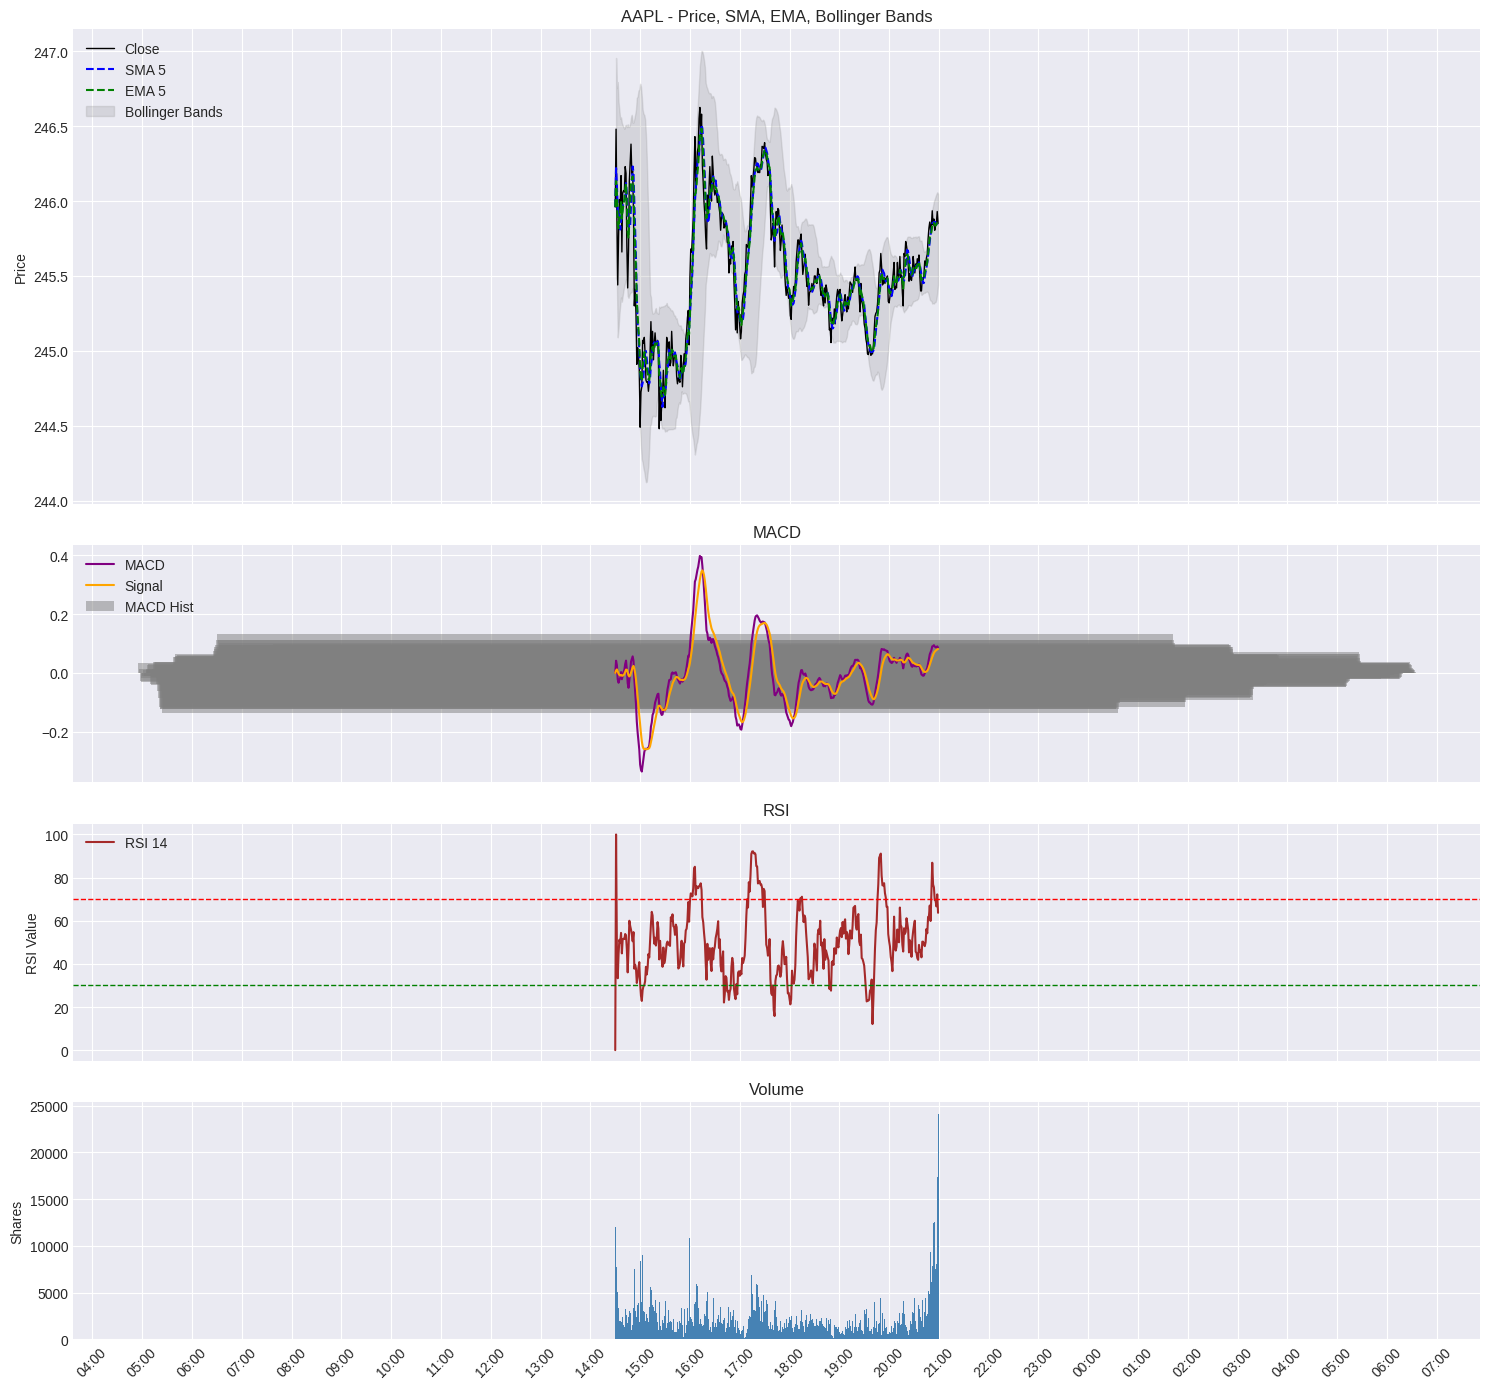

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load data
df = pd.read_csv("Output_Data/new_barsDBase_AAPL.csv", parse_dates=["Timestamp"])
df.set_index("Timestamp", inplace=True)

# Filter for the symbol (e.g., AAPL)
symbol = "AAPL"
df = df[df["Symbol"] == symbol]

# --- Plot Config ---
plt.style.use("seaborn-v0_8-darkgrid")
fig, axs = plt.subplots(4, 1, figsize=(15, 14), sharex=True, gridspec_kw={"height_ratios": [2, 1, 1, 1]})

# --- Candlestick + SMA/EMA + Bollinger Bands ---
axs[0].plot(df.index, df["close"], label="Close", color="black", linewidth=1)
axs[0].plot(df.index, df["SMA_5min"], label="SMA 5", color="blue", linestyle="--")
axs[0].plot(df.index, df["EMA_5min"], label="EMA 5", color="green", linestyle="--")
axs[0].fill_between(df.index, df["BB_upper"], df["BB_lower"], color='gray', alpha=0.2, label="Bollinger Bands")

axs[0].set_title(f"{symbol} - Price, SMA, EMA, Bollinger Bands")
axs[0].set_ylabel("Price")
axs[0].legend(loc="upper left")

# --- MACD ---
axs[1].plot(df.index, df["MACD"], label="MACD", color="purple")
axs[1].plot(df.index, df["MACD_Signal"], label="Signal", color="orange")
axs[1].bar(df.index, df["MACD_Hist"], label="MACD Hist", color="grey", alpha=0.5)
axs[1].set_title("MACD")
axs[1].legend(loc="upper left")

# --- RSI ---
axs[2].plot(df.index, df["RSI_14"], label="RSI 14", color="brown")
axs[2].axhline(70, color='red', linestyle='--', linewidth=1)
axs[2].axhline(30, color='green', linestyle='--', linewidth=1)
axs[2].set_title("RSI")
axs[2].set_ylabel("RSI Value")
axs[2].legend(loc="upper left")

# --- Volume ---
axs[3].bar(df.index, df["volume"], width=0.0008, color="steelblue")
axs[3].set_title("Volume")
axs[3].set_ylabel("Shares")

# --- Formatting ---
axs[-1].xaxis.set_major_locator(mdates.HourLocator(interval=1))
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
